# PCA vs HOPCA

I will write the comments in italian because I truly believe that very few people other than me will read it. If this is an issue tell me and I will translate everything

## Scopo

Lo scopo e' quello di confrontare PCA con la sua versione tensoriale. Questo notebook parte come un proof of concept, quindi per ora lo faccio per 1 solo numero di reynolds (8000) con forte subsampling e vedo se ci sono differenze

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
from utils import print_statistics, load_dataset, scale_and_center_tensors, create_hosvd_reconstruction_gif
import global_variables

In [2]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-8000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
# Load metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)

Nx, Ny = metadata['global']['Nxyz']

# Load grid
X_filename = metadata['global']['grid']['x']
Y_filename = metadata['global']['grid']['y']
X = np.fromfile(data_paths[0] + '/' + X_filename, dtype='<f4').reshape(Ny, Nx)
Y = np.fromfile(data_paths[0] + '/' + Y_filename, dtype='<f4').reshape(Ny, Nx)

# Subsample grid
X_sub = X[::subsample_x, ::subsample_y]
Y_sub = Y[::subsample_x, ::subsample_y]
Ny_sub, Nx_sub = X_sub.shape


In [3]:
component_names = global_variables.component_names
n_species = global_variables.n_species
molar_masses = global_variables.molar_masses
file_key_map = global_variables.file_key_map
Lx, Ly = global_variables.Lx, global_variables.Ly
print(component_names)


['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']


In [4]:
tensors = {path: load_dataset(path, component_names, file_key_map, Ny=Ny, Nx=Nx, n_snapshots=n_snapshots, molar_masses=molar_masses, subsample_x=10, subsample_y=10)
           for path in data_paths}


  Available components in dataset: ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']


In [5]:
print_statistics(tensors, component_names=component_names)


Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              2.108595e-04 4.958064e-04 -4.988369e-25 4.876255e-03
YH2             3.141716e-02 8.368027e-02 0.000000e+00 3.249700e-01
YO              8.207165e-05 2.683234e-04 -1.025646e-14 1.899564e-03
YO2             1.125224e-02 5.756119e-03 1.262478e-07 1.456250e-02
YOH             1.605751e-04 5.228729e-04 -1.954558e-11 3.019940e-03
YH2O            3.061480e-03 6.672779e-03 -2.330029e-07 2.365345e-02
YHO2            2.972886e-07 8.293629e-07 -2.481960e-17 1.084706e-05
YH2O2           1.741783e-08 4.961067e-08 -8.167948e-13 7.718936e-07
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mean: 5.773

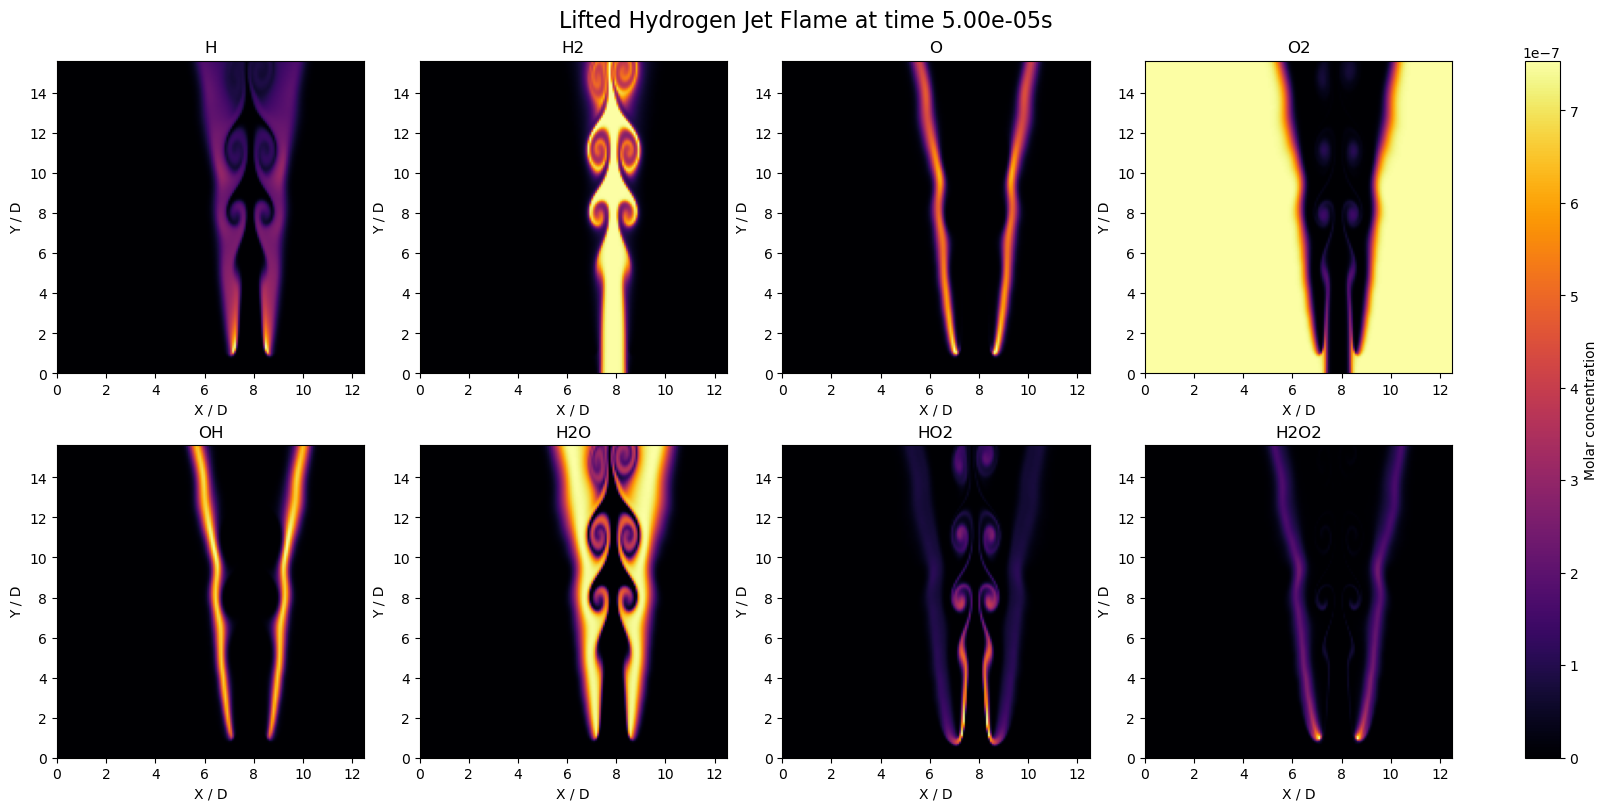

In [6]:
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()
key, tensor = next(iter(tensors.items()))
for idx, ax in enumerate(axes):
    if idx < tensor.shape[2]:
        im = ax.imshow(
            tensor[:, :, idx, t],
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        ax.set_title(f"{component_names[idx][1:]}")
        ax.set_xlabel("X / D")
        ax.set_ylabel("Y / D")
    else:
        ax.axis('off')  # turn off unused axes if fewer than 8 components

fig.colorbar(im, ax=axes, orientation='vertical', label="Molar concentration")
plt.savefig(fname = 'README_PLOTS/original_data_t10.png')
plt.show()


## Preprocessing

Visto che sto lavorando solo con specie chimiche riscalo con logaritmo, dividere per la varianza mi sembra un po' sospetto. Per centrare i dati prendo la media dei valori non nulli.

In [7]:
tensors_scaled_log = scale_and_center_tensors(tensors, component_names)
tensors_scaled = scale_and_center_tensors(tensors, component_names, log_scale=False)


Log scaling and standardization complete.


Log scaling and standardization complete.



In [8]:
print_statistics(tensors_scaled_log, component_names)
print_statistics(tensors_scaled, component_names)



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              2.841125e-20 8.714797e-02 -9.633522e-01 8.609912e-01
YH2             -7.567849e-18 8.127278e-01 -2.647910e+00 3.023160e+00
YO              8.957302e-20 8.202064e-01 -2.394947e+00 2.786432e+00
YO2             2.778246e-19 8.671250e-01 -2.253839e+00 2.830833e+00
YOH             -2.344741e-19 8.129923e-01 -2.358960e+00 2.960161e+00
YH2O            3.100832e-19 7.655634e-01 -2.435521e+00 2.931261e+00
YHO2            5.322376e-20 8.192068e-01 -2.029149e+00 3.364858e+00
YH2O2           1.552945e-17 8.202636e-01 -2.221428e+00 3.607038e+00
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mean: 1

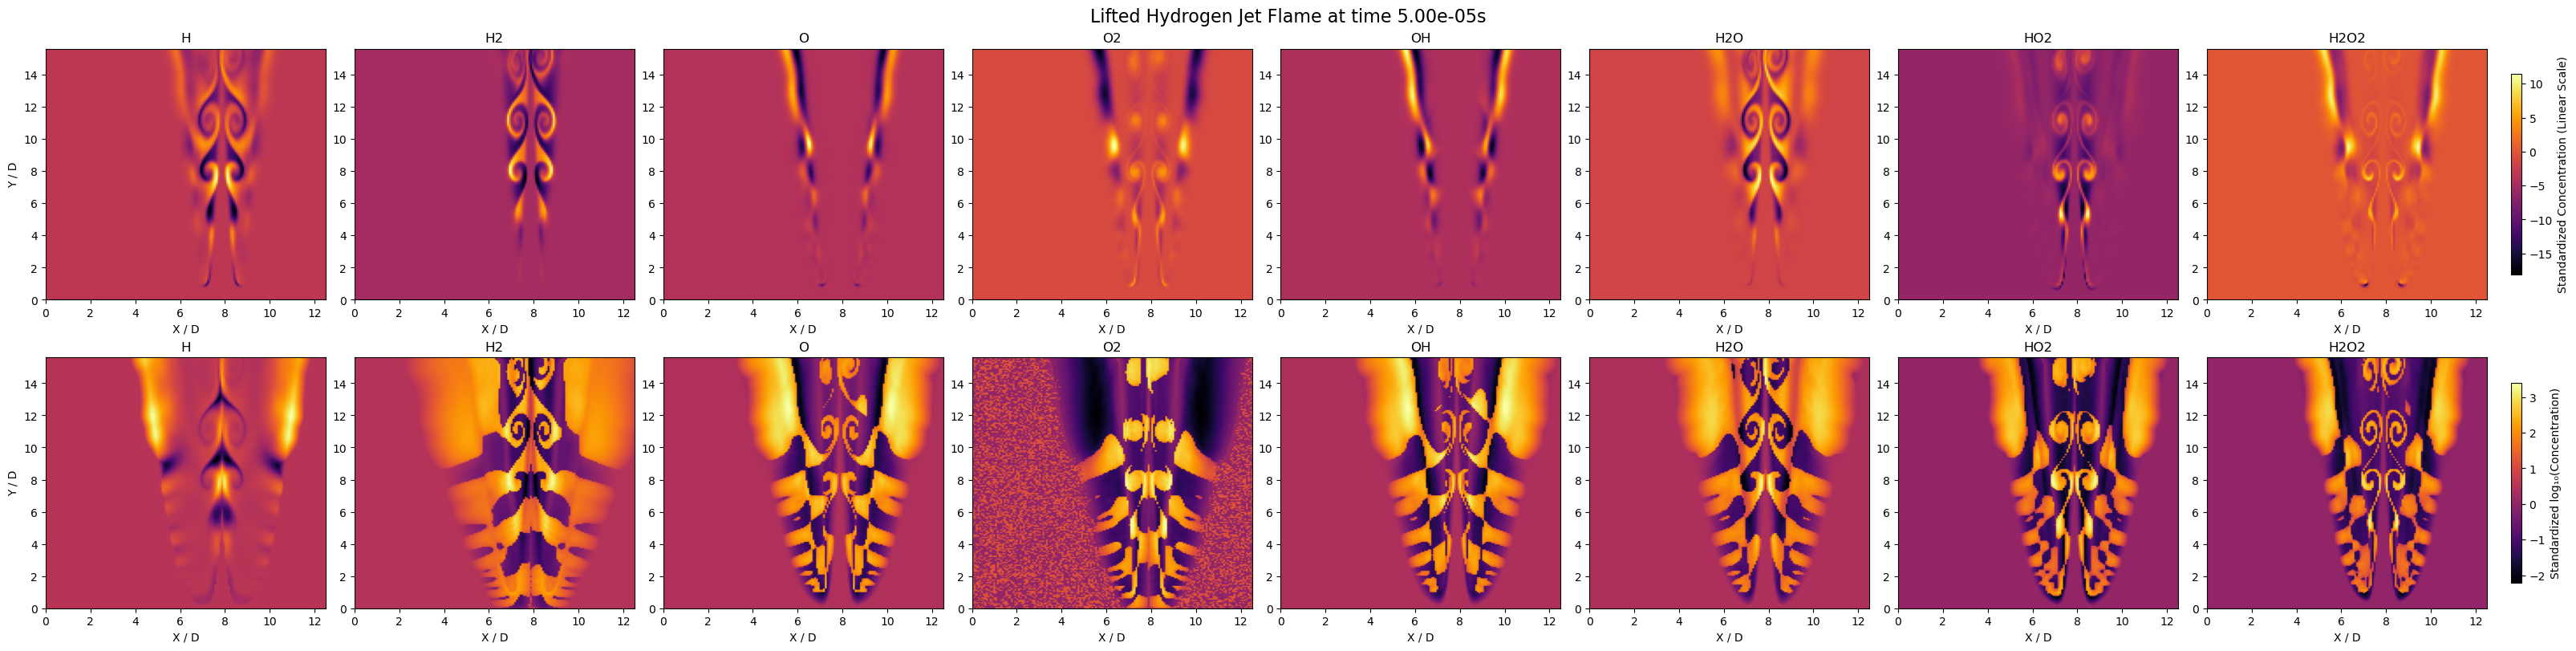

In [9]:
Lx, Ly = 12.5, 15.6        # domain size in D units
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 8, figsize=(32, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

tensor_plot = tensors_scaled[list(tensors_scaled.keys())[0]]
tensor_plot_log = tensors_scaled_log[list(tensors_scaled_log.keys())[0]]

# First row - Non-log scaled
for idx in range(8):
    im = axes[0, idx].imshow(
        tensor_plot[:, :, idx, t],
        cmap='inferno',
        origin='lower',
        extent=[0, Lx, 0, Ly],
        aspect='auto'
    )
    axes[0, idx].set_title(f"{component_names[idx][1:]}")
    axes[0, idx].set_xlabel("X / D")
    if idx == 0:
        axes[0, idx].set_ylabel("Y / D")

# Add colorbar for first row
cbar1 = fig.colorbar(im, ax=axes[0, :], orientation='vertical', 
                      label="Standardized Concentration (Linear Scale)", 
                      pad=0.01, shrink=0.8)

# Second row - Log scaled
for idx in range(8):
    im_log = axes[1, idx].imshow(
        tensor_plot_log[:, :, idx, t],
        cmap='inferno',
        origin='lower',
        extent=[0, Lx, 0, Ly],
        aspect='auto'
    )
    axes[1, idx].set_title(f"{component_names[idx][1:]}")
    axes[1, idx].set_xlabel("X / D")
    if idx == 0:
        axes[1, idx].set_ylabel("Y / D")

# Add colorbar for second row
cbar2 = fig.colorbar(im_log, ax=axes[1, :], orientation='vertical', 
                      label="Standardized log₁₀(Concentration)", 
                      pad=0.01, shrink=0.8)

plt.show()

## PCA classica

Per prima cosa bisogna implementare la PCA nella sua forma piu' tradizionale


PCA ANALYSIS - LINEAR SCALE

CONTRIBUTING SPECIES FOR EACH PCA MODE - Linear Scale
 Mode   1st Species  2nd Species   3rd Species  4th Species   5th Species   6th Species  7th Species   8th Species
    1   YO2 (13.7%)   YO (13.6%)   YOH (13.4%)  YH2 (12.9%)  YH2O (12.8%)  YHO2 (11.8%)   YH (11.5%) YH2O2 (10.3%)
    2  YHO2 (17.4%)  YH2 (16.6%)  YH2O (16.3%)   YO (15.1%) YH2O2 (11.1%)    YH (10.7%)   YOH (7.0%)    YO2 (5.7%)
    3   YO2 (17.4%)  YOH (17.4%) YH2O2 (17.3%)   YH (17.1%)  YHO2 (10.1%)    YH2 (9.7%)    YO (5.7%)   YH2O (5.3%)
    4 YH2O2 (22.8%)   YH (22.5%)    YO (15.1%) YH2O (14.9%)    YO2 (9.7%)    YOH (9.4%)  YHO2 (3.0%)    YH2 (2.7%)
    5    YO (14.1%) YH2O (13.8%) YH2O2 (13.7%)   YH (13.6%)   YO2 (12.2%)   YOH (11.9%) YHO2 (10.4%)   YH2 (10.3%)
    6   YH2 (18.0%) YHO2 (17.5%)   YOH (15.9%)  YO2 (15.8%)    YH (12.0%) YH2O2 (11.9%)    YO (4.7%)   YH2O (4.3%)
    7  YHO2 (18.6%)  YH2 (17.5%)  YH2O (17.0%)   YO (15.8%)  YH2O2 (9.2%)     YH (8.6%)   YOH (7.2%)    YO2 (6.

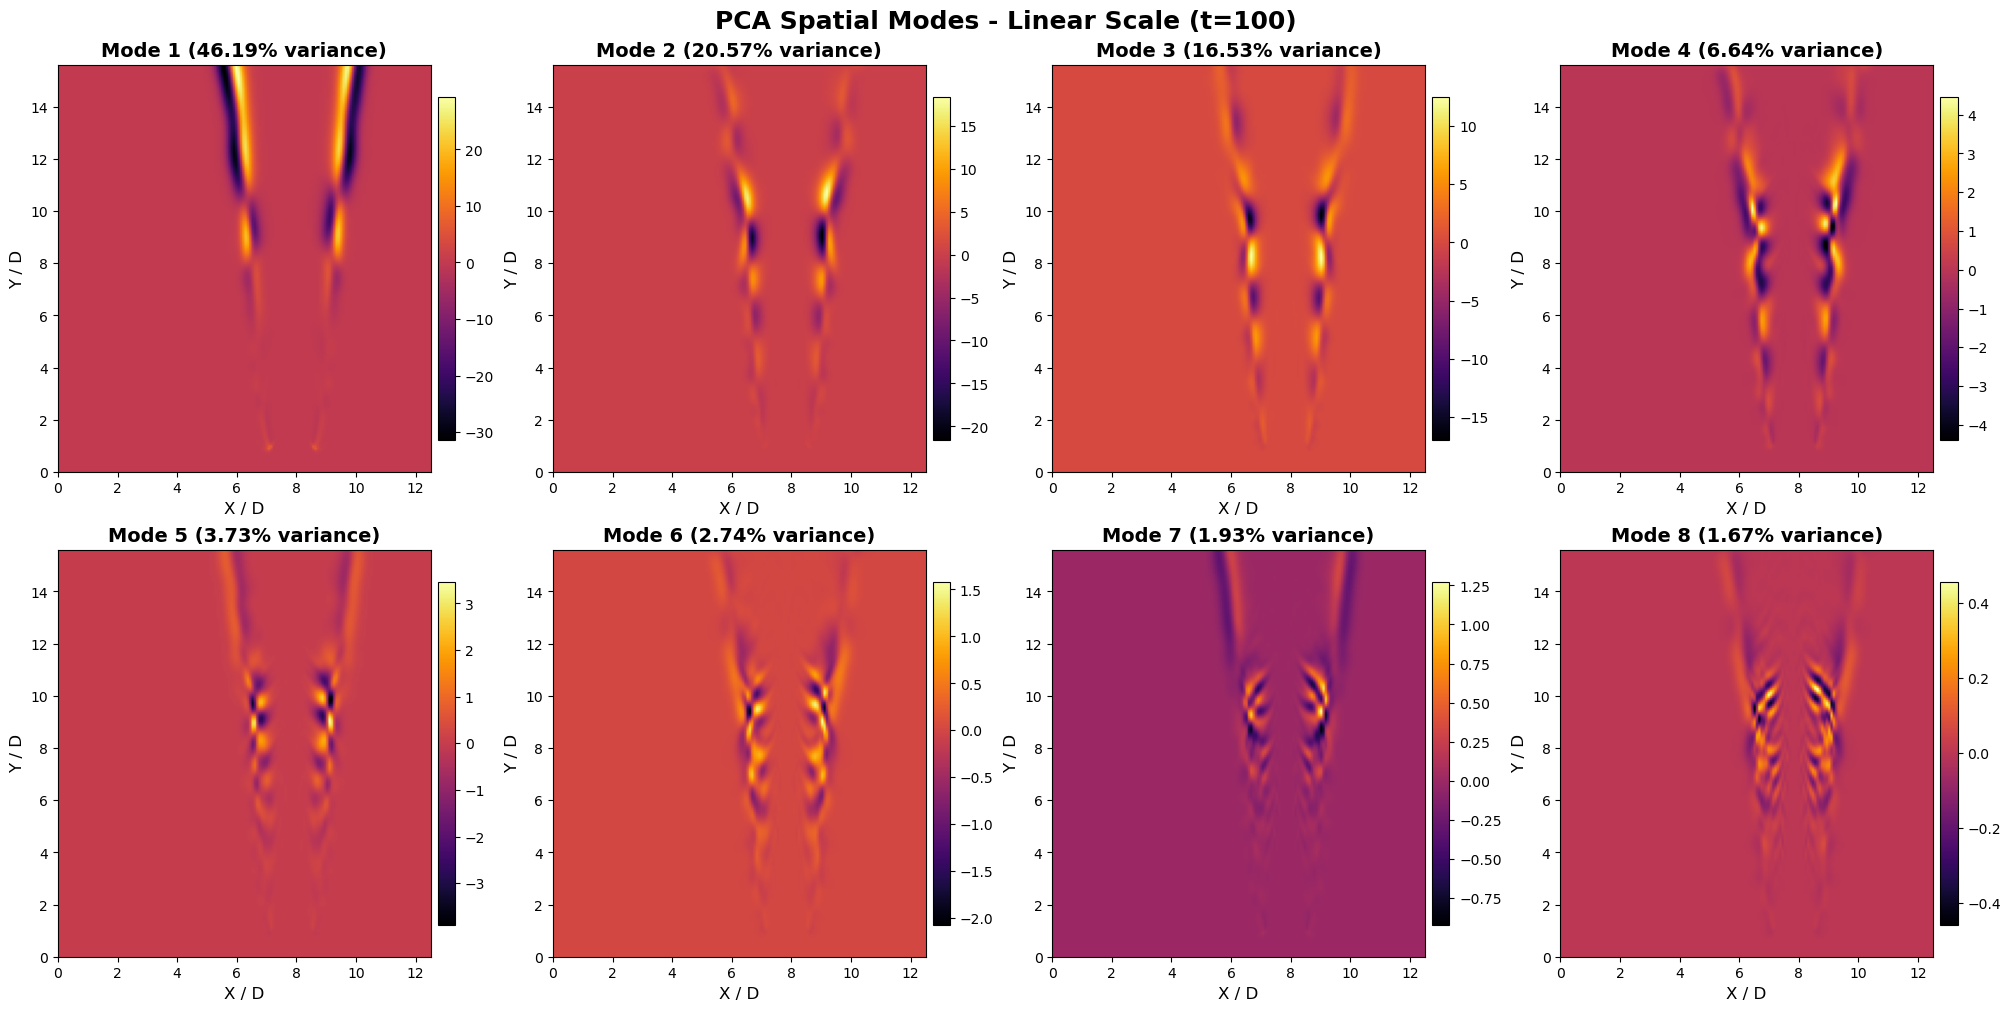


PCA ANALYSIS - LOG SCALE

CONTRIBUTING SPECIES FOR EACH PCA MODE - Log Scale
 Mode   1st Species   2nd Species  3rd Species  4th Species   5th Species   6th Species 7th Species   8th Species
    1   YO2 (14.1%)   YOH (13.9%)   YO (13.7%) YH2O (13.1%)   YH2 (12.6%)  YHO2 (11.9%)  YH (10.7%) YH2O2 (10.0%)
    2  YHO2 (17.2%)   YH2 (16.6%) YH2O (15.5%)   YO (14.7%) YH2O2 (12.0%)    YH (11.7%)  YOH (6.4%)    YO2 (5.8%)
    3 YH2O2 (17.7%)    YH (17.5%)  YOH (17.3%)  YO2 (17.1%)  YHO2 (10.4%)   YH2 (10.2%) YH2O (5.0%)     YO (4.9%)
    4    YH (23.0%) YH2O2 (22.9%) YH2O (16.0%)   YO (15.7%)   YO2 (10.0%)    YOH (9.4%) YHO2 (1.6%)    YH2 (1.5%)
    5 YH2O2 (14.6%)    YH (14.2%)   YO (13.0%) YH2O (12.4%)   YOH (12.0%)  YHO2 (11.7%) YO2 (11.1%)   YH2 (11.0%)
    6  YHO2 (18.0%)   YH2 (17.8%)  YO2 (16.8%)  YOH (15.7%)    YH (11.4%) YH2O2 (11.1%) YH2O (5.4%)     YO (3.8%)
    7  YH2O (18.6%)  YHO2 (17.7%)  YH2 (16.9%)   YO (16.4%)    YOH (9.5%)  YH2O2 (8.0%)   YH (7.6%)    YO2 (5.4%)
    8   YO

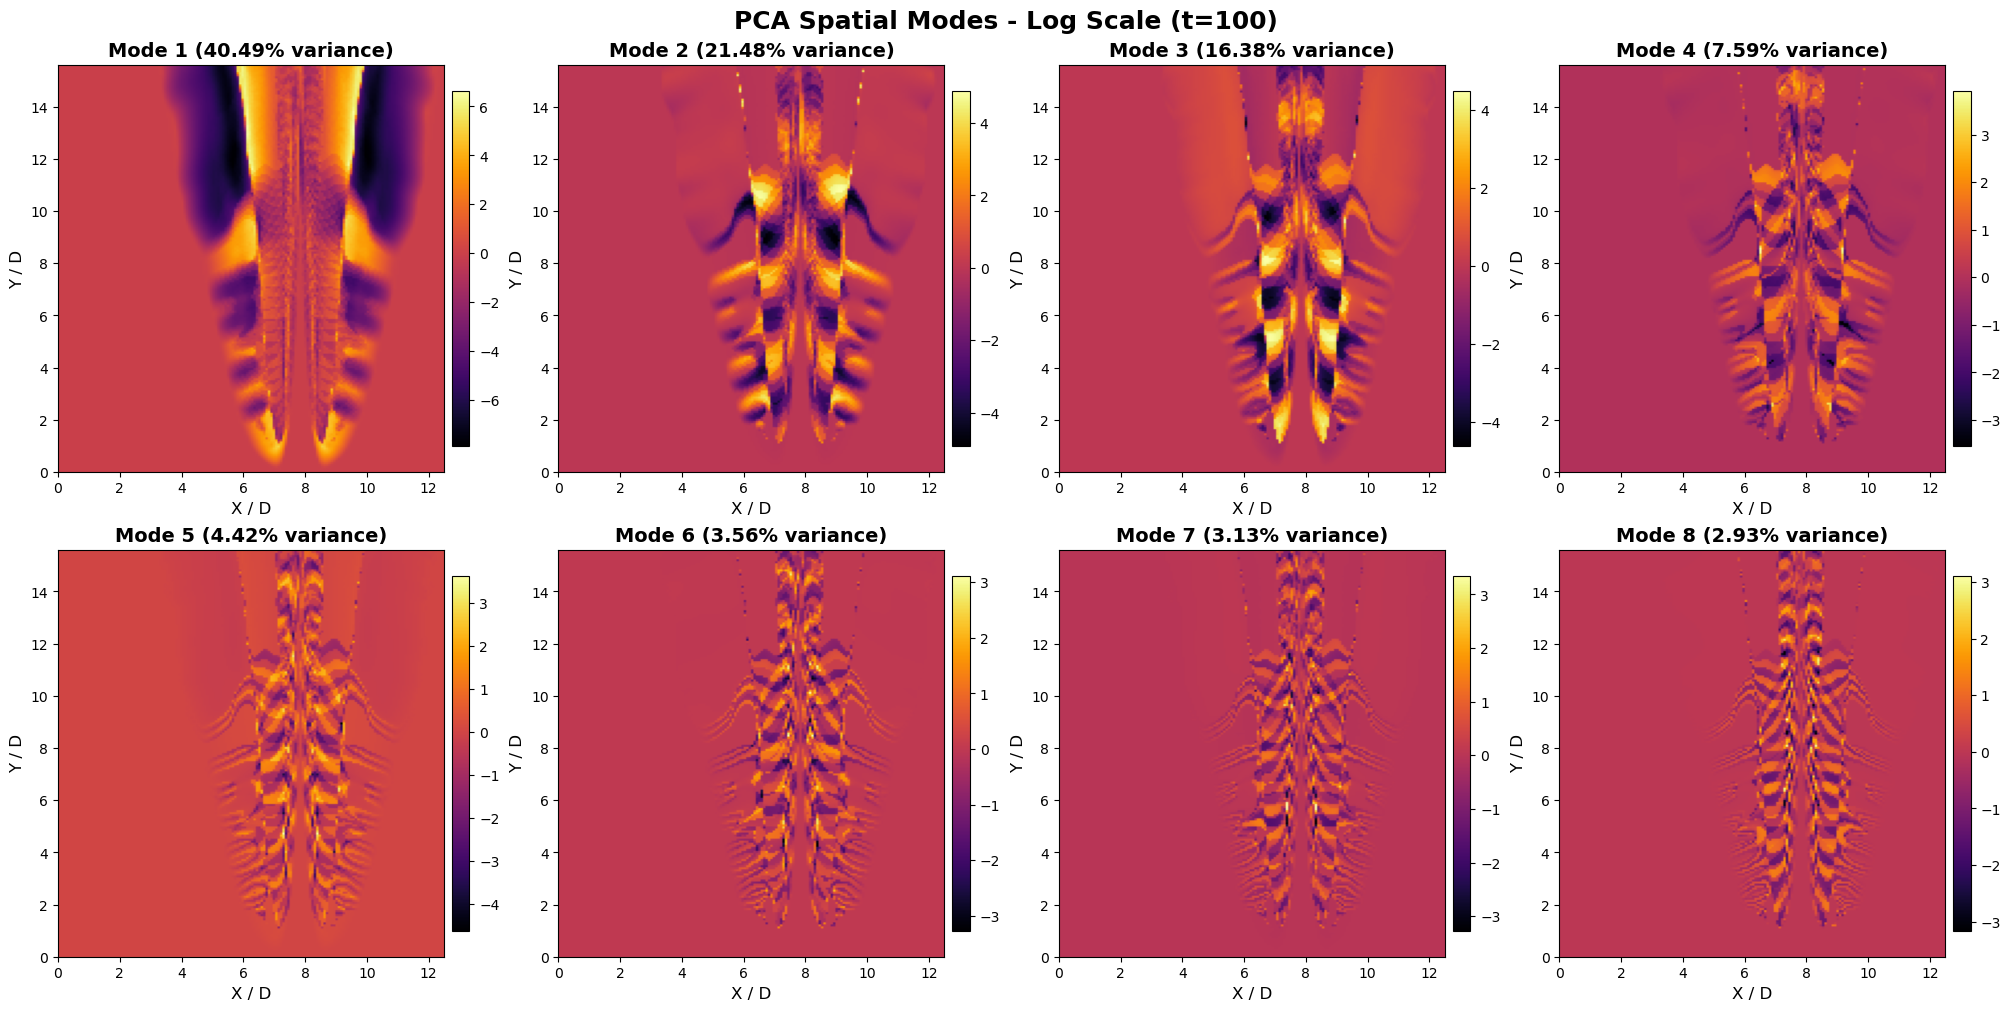

In [10]:
# Dictionary to store results for both cases
pca_results = {}

for case_name, tensors_dict in [("Linear Scale", tensors_scaled), ("Log Scale", tensors_scaled_log)]:
    print("\n" + "="*100)
    print(f"PCA ANALYSIS - {case_name.upper()}")
    print("="*100)
    
    for dataset_path, tensor in tensors_dict.items():
        X = tensor.reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
        U, sigma, V = np.linalg.svd(X, full_matrices=False)
        loadings = V.T  # Now shape is (n_components x n_modes)
        
        summary_data = []
        for mode in range(n_species):
            mode_vector = np.abs(loadings[:, mode])
            total = np.sum(mode_vector)
            rel_contrib = 100 * mode_vector / total if total > 0 else np.zeros_like(mode_vector)
            # Get top species
            top_indices = np.argsort(rel_contrib)[::-1]
            top_species = []
            for idx in top_indices:
                top_species.append(f"{component_names[idx]} ({rel_contrib[idx]:.1f}%)")
            
            summary_data.append({
                'Mode': mode + 1,
                '1st Species': top_species[0],
                '2nd Species': top_species[1],
                '3rd Species': top_species[2],
                '4th Species': top_species[3],
                '5th Species': top_species[4],
                '6th Species': top_species[5],
                '7th Species': top_species[6],
                '8th Species': top_species[7],
            })
        
        df_summary = pd.DataFrame(summary_data)
        print("\n" + "="*80)
        print(f"CONTRIBUTING SPECIES FOR EACH PCA MODE - {case_name}")
        print("="*80)
        print(df_summary.to_string(index=False))
        print("="*80)
        
        Phi = U
        print(f"\nSpatial modes shape: {U.shape}")
        T = np.diag(sigma) @ V
        energy = sigma**2
        energy_fraction = energy / np.sum(energy)
        print(f"Total spatial features: {X.shape[0]}")
        print("\nTop modes energy content:")
        for i in range(min(5, len(energy_fraction))):
            print(f"  Mode {i+1}: {energy_fraction[i]*100:.2f}%")
        
        # Store results
        pca_results[case_name] = {
            'Phi': Phi,
            'sigma': sigma,
            'energy_fraction': energy_fraction
        }
        
        # Plot spatial modes
        Lx, Ly = 12.5, 15.6  # domain size in D units
        t_snapshot = 100  
        fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
        fig.suptitle(f"PCA Spatial Modes - {case_name} (t={t_snapshot})", 
                     fontsize=18, fontweight='bold')
        axes = axes.flatten()
        
        for idx in range(n_species):
            phi_mode = (Phi * sigma)[:, idx].reshape(Ny_sub, Nx_sub, 200)
            phi_snapshot = np.flip(phi_mode[:, :, t_snapshot], axis=0)
            
            im = axes[idx].imshow(
                phi_snapshot,
                cmap='inferno',
                extent=[0, Lx, 0, Ly],
                aspect='auto',
                vmin=phi_snapshot.min(),  # Independent min
                vmax=phi_snapshot.max()   # Independent max
            )
            axes[idx].set_title(
                f"Mode {idx+1} ({energy_fraction[idx]*100:.2f}% variance)",
                fontsize=14,
                fontweight='bold'
            )
            axes[idx].set_xlabel("X / D", fontsize=12)
            axes[idx].set_ylabel("Y / D", fontsize=12)
            axes[idx].tick_params(labelsize=10)
            
            # Add colorbar for each subplot
            cbar = fig.colorbar(im, ax=axes[idx], orientation='vertical', pad=0.02, fraction=0.046)
            cbar.ax.tick_params(labelsize=10)
        
        # Save with different filename for each case
        #filename = f"README_PLOTS/pca_spatial_modes_{case_name.lower().replace(' ', '_')}.png"
        #plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

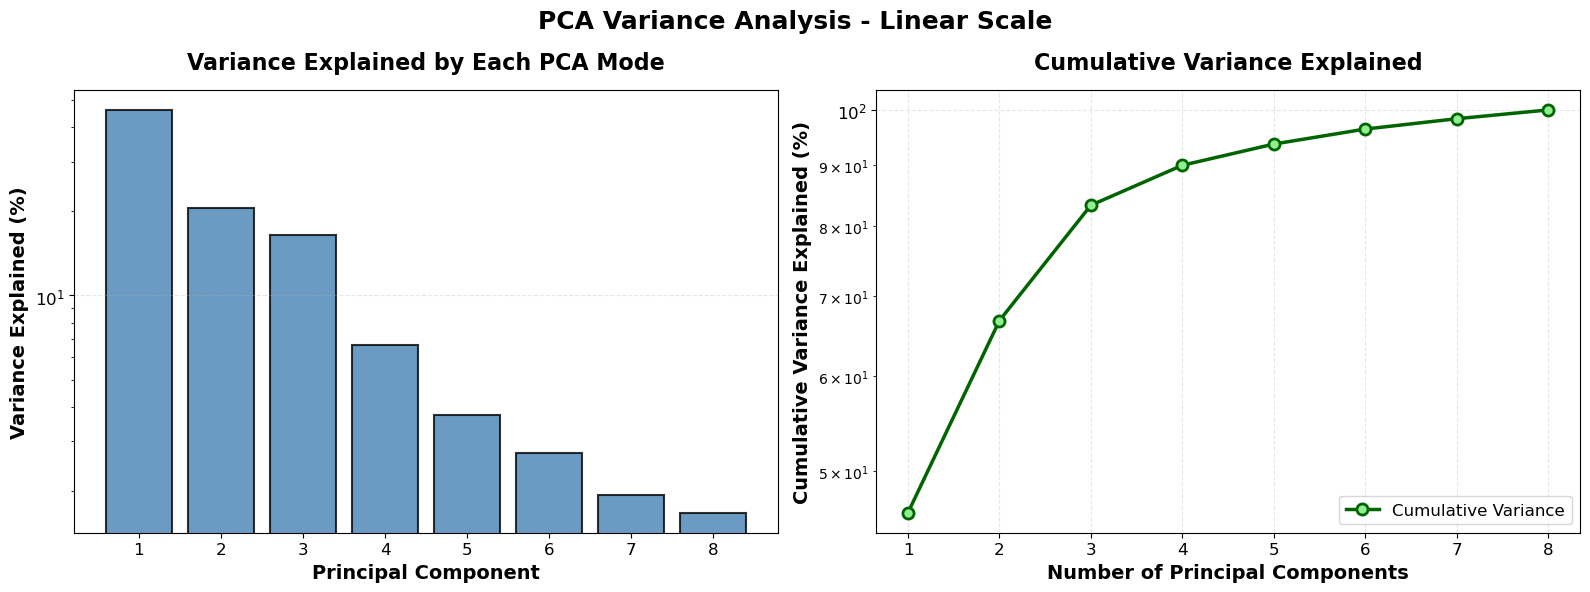


Variance Explained Summary - Linear Scale
  First mode: 46.19%
  First 2 modes: 66.76%
  First 3 modes: 83.29%
  First 4 modes: 89.93%


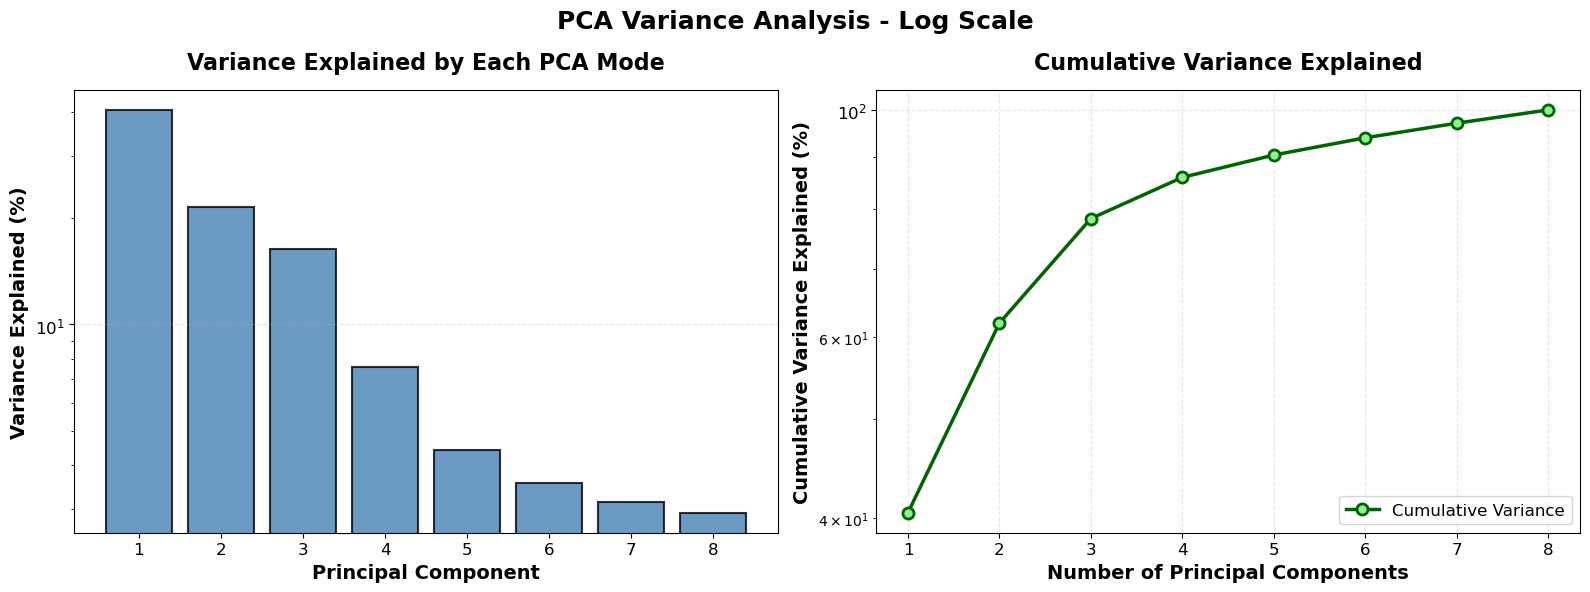


Variance Explained Summary - Log Scale
  First mode: 40.49%
  First 2 modes: 61.98%
  First 3 modes: 78.36%
  First 4 modes: 85.95%


In [12]:
for case_name, results in pca_results.items():
    sigma = results['sigma']
    variance_explained = sigma**2 / np.sum(sigma**2)
    cumulative_variance = np.cumsum(variance_explained)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'PCA Variance Analysis - {case_name}', fontsize=18, fontweight='bold')
    
    # Variance explained per mode
    ax1.bar(range(1, len(variance_explained) + 1), variance_explained * 100, 
            color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Principal Component', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Variance Explained (%)', fontsize=14, fontweight='bold')
    ax1.set_title('Variance Explained by Each PCA Mode', fontsize=16, fontweight='bold', pad=15)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.tick_params(labelsize=12)
    ax1.set_xticks(range(1, len(variance_explained) + 1))
    ax1.set_yscale("log")
    
    # Cumulative variance explained
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, 
             marker='o', markersize=8, linewidth=2.5, color='darkgreen', 
             markerfacecolor='lightgreen', markeredgewidth=2, markeredgecolor='darkgreen',
             label='Cumulative Variance')
    ax2.set_xlabel('Number of Principal Components', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=14, fontweight='bold')
    ax2.set_title('Cumulative Variance Explained', fontsize=16, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(fontsize=12, loc='lower right')
    ax2.tick_params(labelsize=12)
    ax2.set_xticks(range(1, len(cumulative_variance) + 1))
    ax2.set_yscale("log")
    
    plt.tight_layout()
    filename = f"README_PLOTS/pca_variance_{case_name.lower().replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"Variance Explained Summary - {case_name}")
    print(f"{'='*60}")
    print(f"  First mode: {variance_explained[0]*100:.2f}%")
    print(f"  First 2 modes: {cumulative_variance[1]*100:.2f}%")
    print(f"  First 3 modes: {cumulative_variance[2]*100:.2f}%")
    print(f"  First 4 modes: {cumulative_variance[3]*100:.2f}%")
    print(f"{'='*60}")

## HOSVD

Che e' poi preso come caso di fatto equivalente a PCA. Nel caso che si parta a troncare (che ahime' penso si dovra' fare), bisogna che ti metti li' e fai HOOI per essere ben fedele

In [13]:
decomposition_results = {}  # store factors and cores per dataset

for dataset_path, tensor in tensors_scaled.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset: {dataset_path}")
    print("=" * 100)
    
    factors = []
    for i in tqdm(range(tensor.ndim)):
        U, _, _ = np.linalg.svd(tl.unfold(tensor, mode=i), full_matrices=False)
        factors.append(U)

    core = multi_mode_dot(tensor, [U.T for U in factors], modes=range(tensor.ndim))
    print("done")
    reconst = multi_mode_dot(core, factors, modes=range(tensor.ndim))
    
    # check reconstruction accuracy
    close = np.allclose(reconst, tensor, rtol=1e-5, atol=1e-8)
    error = np.linalg.norm(np.subtract(reconst, tensor)) / np.linalg.norm(tensor)
    
    print(f"  Reconstruction close: {close}")
    print(f"  Relative reconstruction error: {error:.6e}")
    print("-" * 100)
    
    # store results
    decomposition_results[dataset_path] = {
        "core": core,
        "factors": factors,
    }

print("\n" + "=" * 100)


Performing HOSVD for dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3


100%|██████████| 4/4 [00:16<00:00,  4.06s/it]


done
  Reconstruction close: True
  Relative reconstruction error: 2.773631e-15
----------------------------------------------------------------------------------------------------



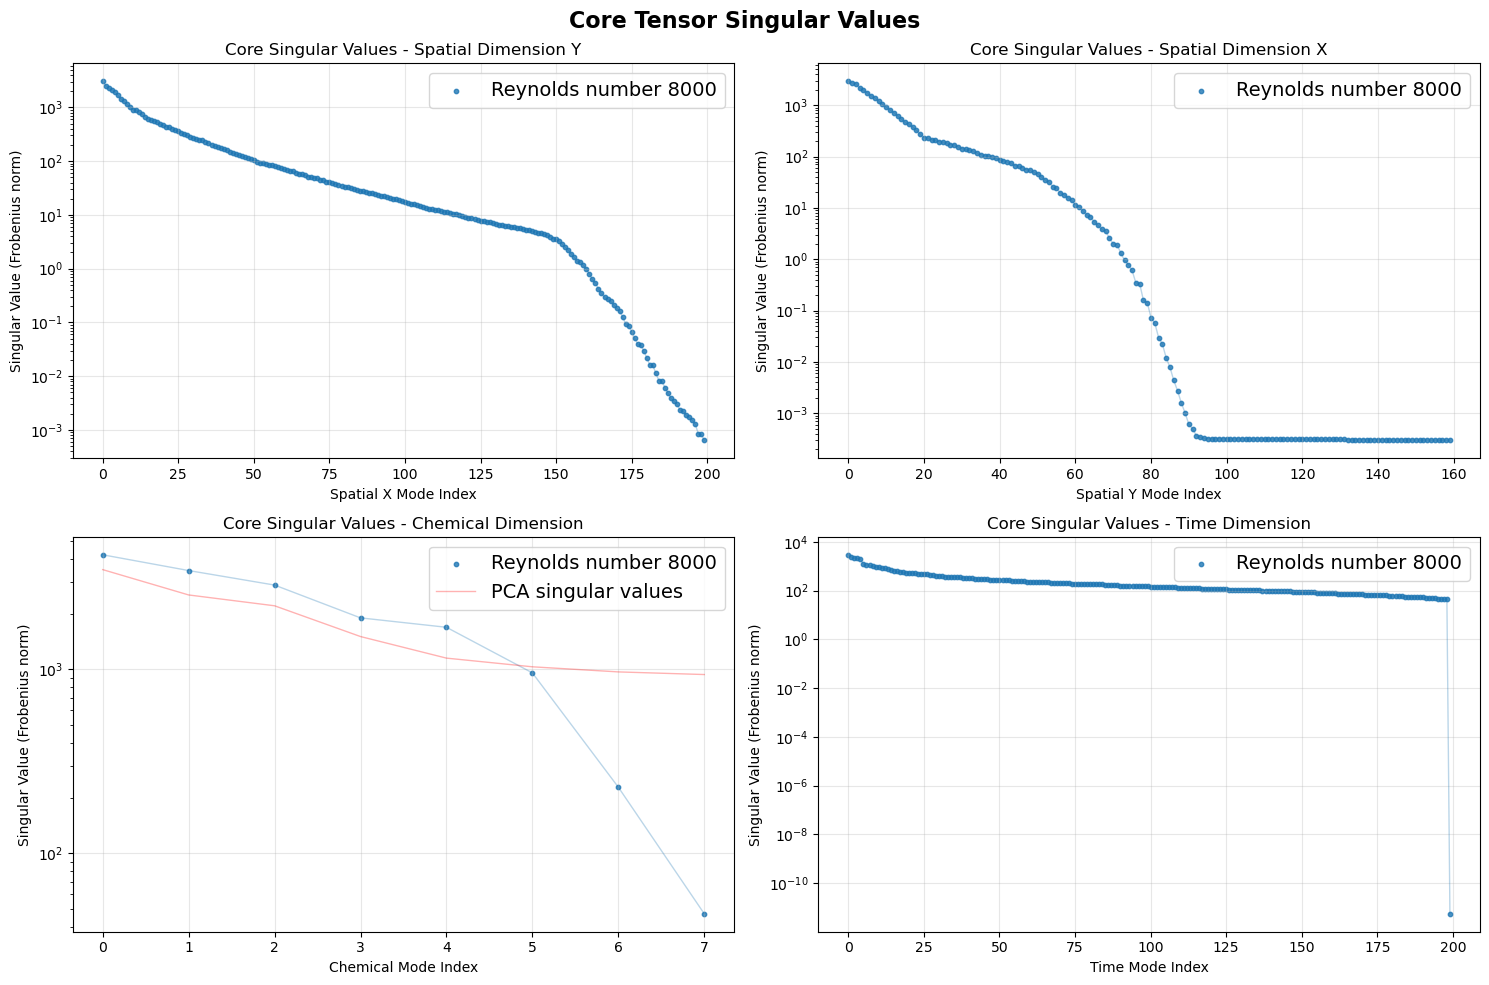

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(decomposition_results)))

for idx, (key, f) in enumerate(decomposition_results.items()):
        core = f['core']
        dataset_name = f"Reynolds number {key.split("-")[-1][:4]}"
        color = colors[idx]
        
        sv_0 = [np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])]
        ax = axes[0, 0]
        ax.scatter(range(len(sv_0)), sv_0, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_0)), sv_0, color=color, alpha=0.3, linewidth=1)
        
        sv_1 = [np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])]
        ax = axes[0, 1]
        ax.scatter(range(len(sv_1)), sv_1, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_1)), sv_1, color=color, alpha=0.3, linewidth=1)
        
        sv_chem = [np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])]
        ax = axes[1, 0]
        ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=0.3, linewidth=1)
        ax.plot(range(len(sv_chem)), sigma, color='red', alpha=0.3, linewidth=1, label="PCA singular values")
        
        sv_time = [np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])]
        ax = axes[1, 1]
        ax.scatter(range(len(sv_time)), sv_time, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_time)), sv_time, color=color, alpha=0.3, linewidth=1)

ax = axes[0, 0]
ax.set_xlabel('Spatial X Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension Y') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[0, 1]
ax.set_xlabel('Spatial Y Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension X') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 0]
ax.set_xlabel('Chemical Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Chemical Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 1]
ax.set_xlabel('Time Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Time Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

fig.suptitle('Core Tensor Singular Values', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('README_PLOTS/hosvd_core_vals.png', dpi=300, bbox_inches='tight')

plt.show()

In [15]:
# Print HOSVD loadings for all 8 species
for dataset_path, result in decomposition_results.items():
    factors = result['factors']
    U_chem = factors[2]  # Chemical dimension factor (3rd dimension)
    
    summary_data = []
    
    for mode in range(n_species):
        mode_vector = np.abs(U_chem[:, mode])
        total = np.sum(mode_vector)
        rel_contrib = 100 * mode_vector / total if total > 0 else np.zeros_like(mode_vector)
        
        # Get all species in descending order
        sorted_indices = np.argsort(rel_contrib)[::-1]
        
        species_data = {}
        for rank, idx in enumerate(sorted_indices):
            species_data[f'{rank+1}st Species' if rank == 0 else f'{rank+1}nd Species' if rank == 1 else f'{rank+1}rd Species' if rank == 2 else f'{rank+1}th Species'] = \
                f"{component_names[idx]} ({rel_contrib[idx]:.1f}%)"
        
        summary_data.append({
            'Mode': mode + 1,
            **species_data
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n" + "="*120)
    print(f"CONTRIBUTING SPECIES FOR EACH HOSVD MODE (Chemical Dimension) - {dataset_path}")
    print("="*120)
    print(df_summary.to_string(index=False))
    print("="*120)


CONTRIBUTING SPECIES FOR EACH HOSVD MODE (Chemical Dimension) - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species 2nd Species   3rd Species   4th Species 5th Species  6th Species 7th Species  8th Species
    1  YH2O (22.2%) YH2 (18.9%)  YHO2 (18.3%) YH2O2 (14.8%) YO2 (14.4%)    YH (4.9%)   YO (3.6%)   YOH (3.0%)
    2    YO (34.9%) YOH (33.5%) YH2O2 (13.3%)    YO2 (5.7%)  YH2 (5.2%)  YH2O (4.2%) YHO2 (2.9%)    YH (0.4%)
    3   YO2 (24.9%) YH2 (22.8%) YH2O2 (19.1%)  YH2O (13.7%) YOH (10.9%)  YHO2 (3.8%)   YH (3.1%)    YO (1.9%)
    4  YHO2 (39.8%)  YO (11.7%) YH2O2 (10.1%)  YH2O (10.0%)  YH2 (8.8%)   YOH (8.8%)  YO2 (7.6%)    YH (3.2%)
    5 YH2O2 (34.3%) YO2 (31.0%)   YOH (10.8%)     YO (8.2%) YH2O (7.8%)   YH2 (4.6%)   YH (1.8%)  YHO2 (1.7%)
    6    YO (31.3%) YOH (30.6%) YH2O2 (12.2%)  YHO2 (10.2%)  YO2 (9.4%)  YH2O (4.5%)  YH2 (1.0%)    YH (0.8%)
    7    YH (76.0%) YH2O (9.0%)    YH2 (7.7%)     YO (2.9%)  YO2 (2.4%)   YOH (0.9%)

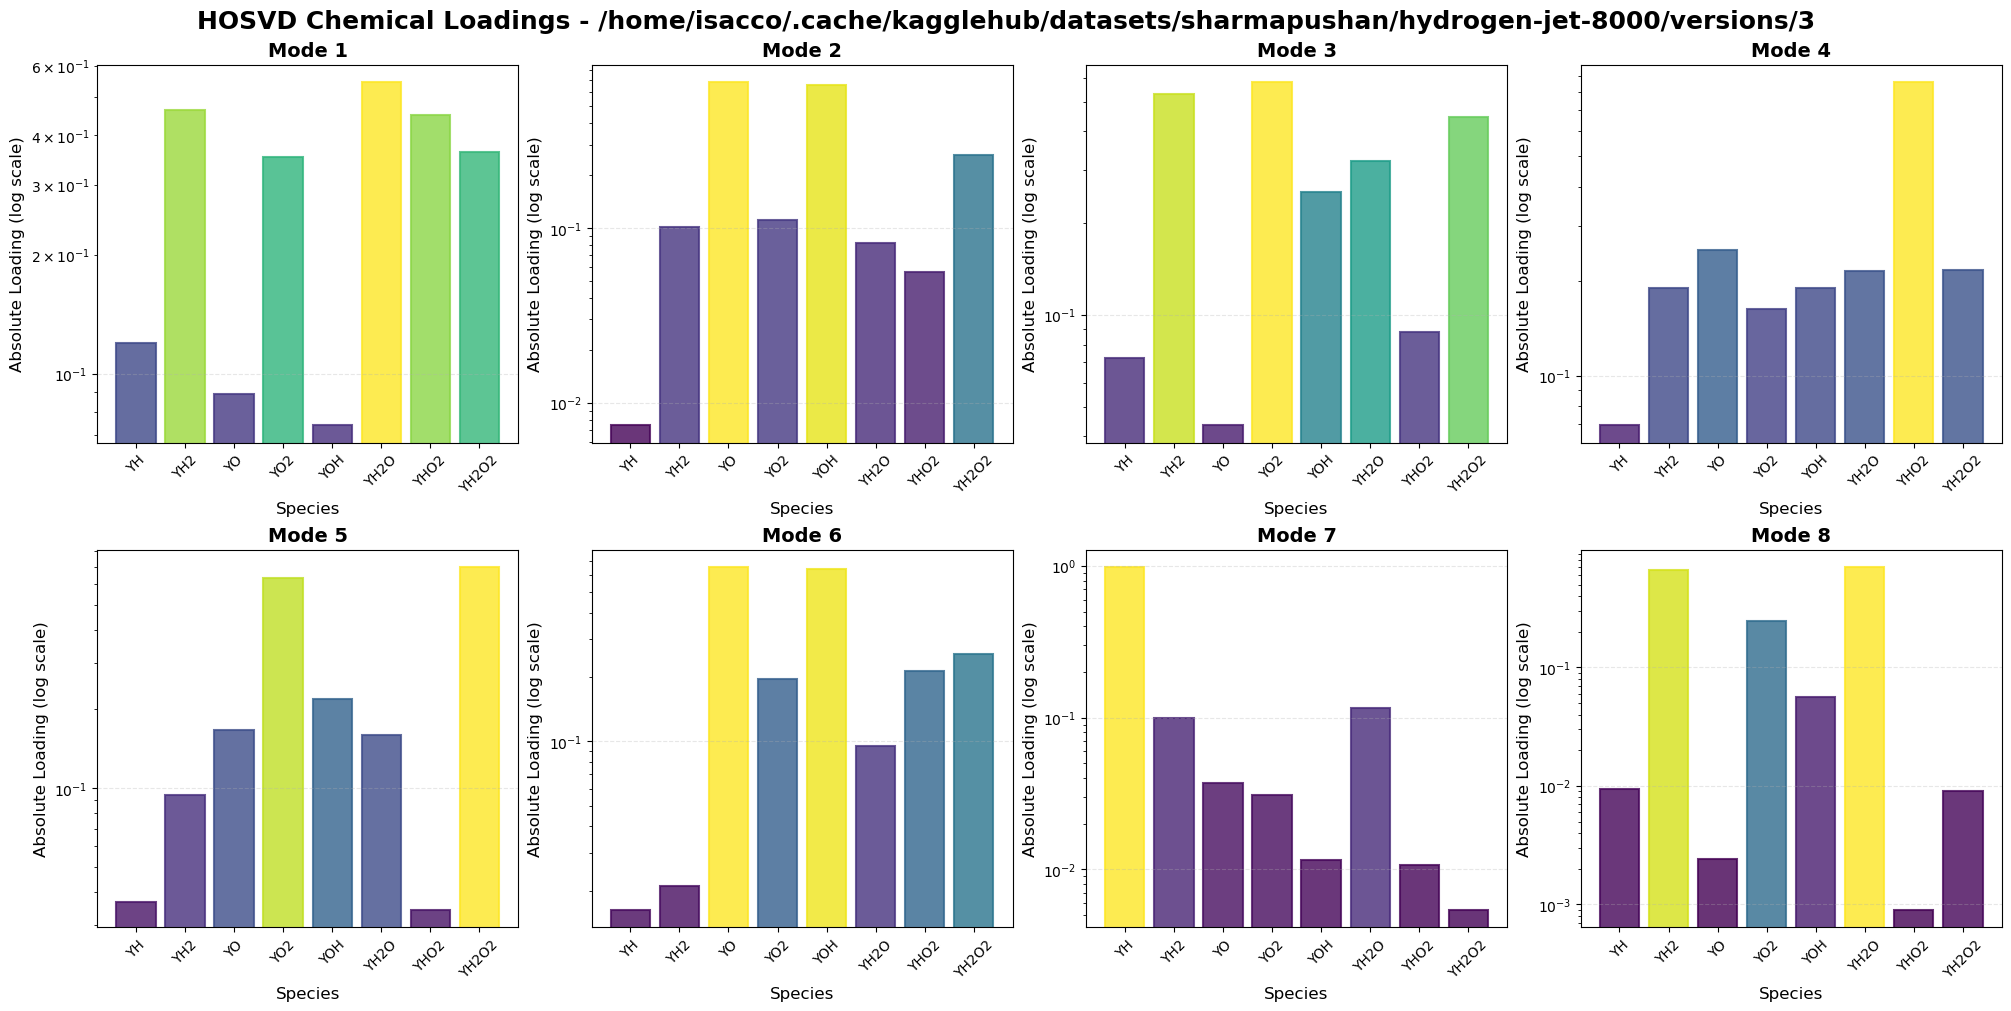

In [16]:
# Visualize HOSVD loadings for all 8 modes in a 2x4 grid
for dataset_path, result in decomposition_results.items():
    factors = result['factors']
    U_chem = factors[2]  # Chemical dimension factor (3rd dimension)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    fig.suptitle(f"HOSVD Chemical Loadings - {dataset_path}", fontsize=18, fontweight='bold')
    
    axes = axes.flatten()
    
    for mode in range(8):
        mode_vector = np.abs(U_chem[:, mode])
        
        ax = axes[mode]
        bars = ax.bar(component_names, mode_vector, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Color the bars differently based on magnitude
        colors = plt.cm.viridis(mode_vector / mode_vector.max())
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        ax.set_yscale('log')
        ax.set_title(f'Mode {mode + 1}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Species', fontsize=12)
        ax.set_ylabel('Absolute Loading (log scale)', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.savefig(f'README_PLOTS/hosvd_chemical_loadings_{dataset_path.split("/")[-1]}.png', dpi=300, bbox_inches='tight')
    plt.show()

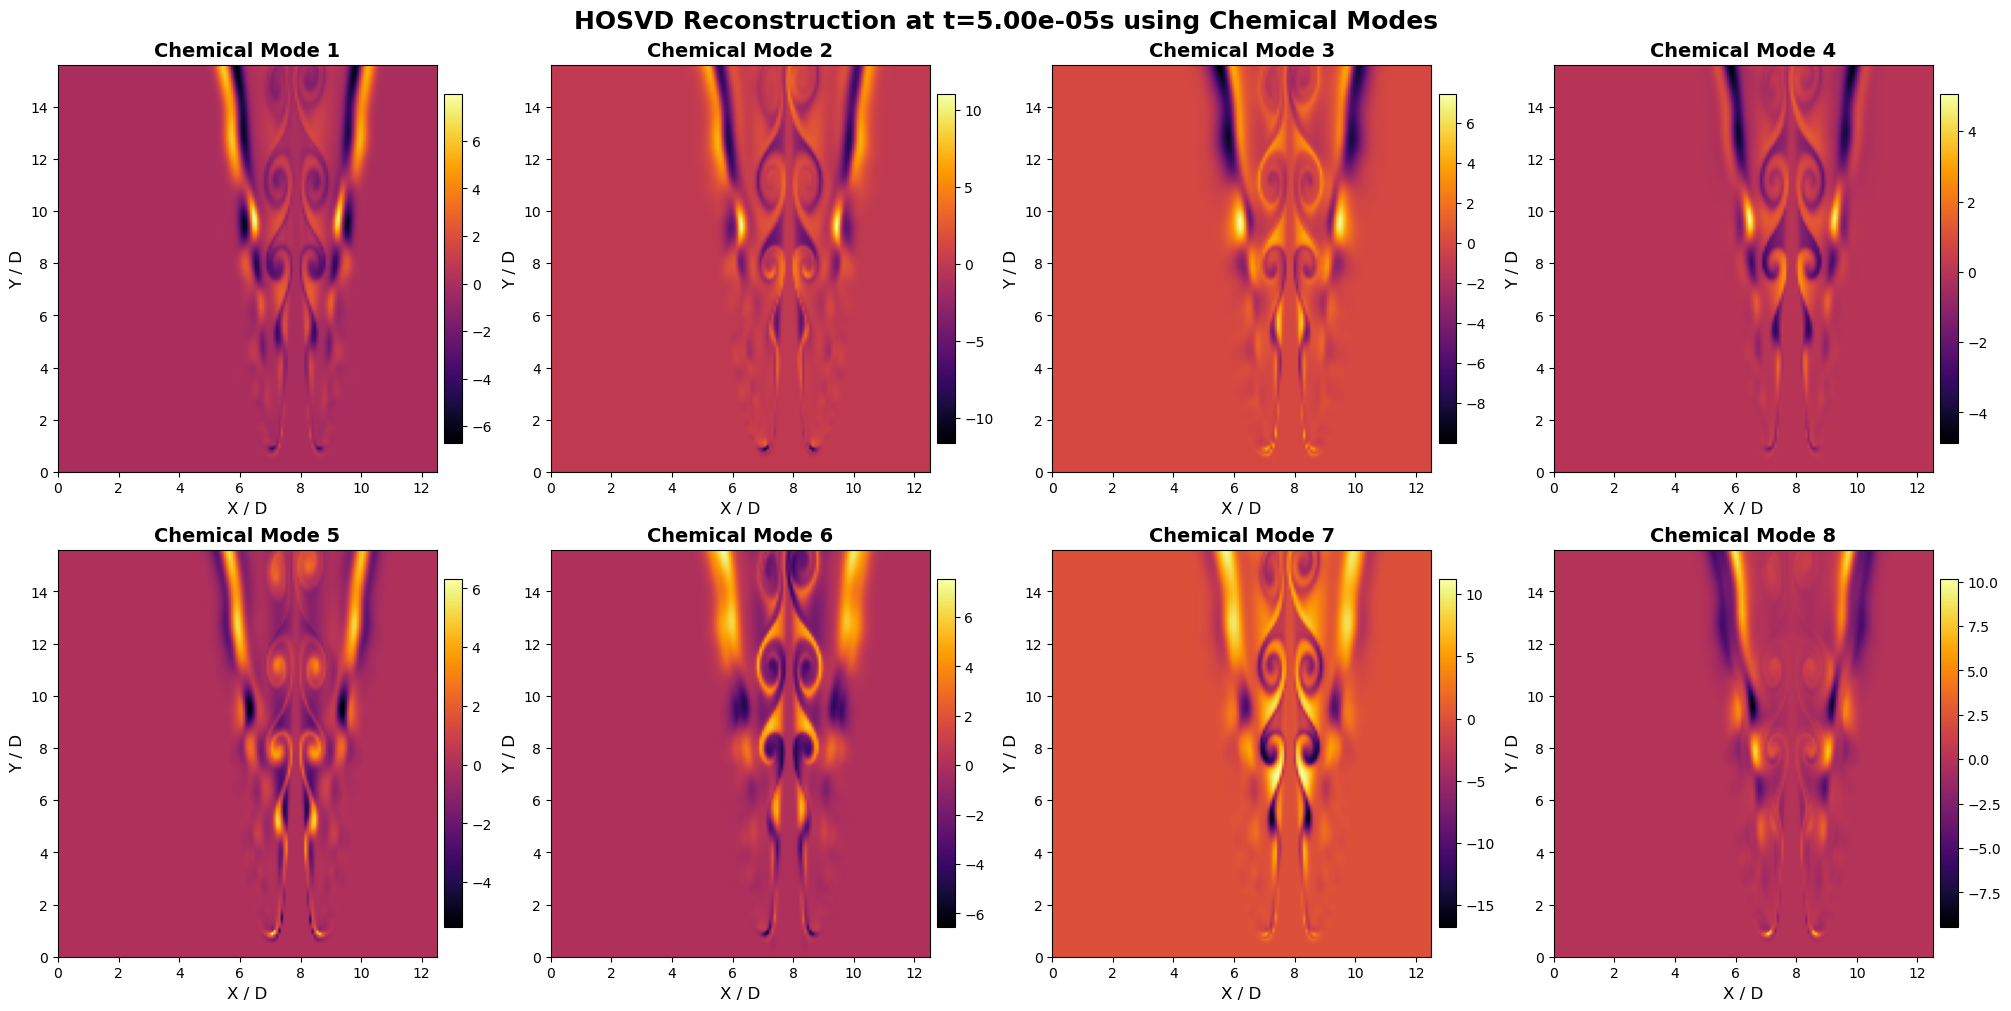

In [17]:
for dataset_path, result in decomposition_results.items():
    factors = result['factors']
    core = result['core']
    
    U_y = factors[0]      # Spatial Y factor (Ny_sub, Ny_sub)
    U_x = factors[1]      # Spatial X factor (Nx_sub, Nx_sub)
    U_chem = factors[2]   # Chemical dimension factor (8, 8)
    U_time = factors[3]   # Time factor (200, 200)
    
    t = 10  # Time snapshot
    Lx, Ly = 12.5, 15.6  # domain size in D units
    time_conversion_factor = 5e-06
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    fig.suptitle(f"HOSVD Reconstruction at t={t * time_conversion_factor:.2e}s using Chemical Modes", 
                 fontsize=18, fontweight='bold')
    
    axes = axes.flatten()
    
    for mode in range(8):
        reconstructed = multi_mode_dot(core, [U_y, U_x,U_chem[:, mode], U_time], modes=[0,1,2,3])
        reconstructed_t10 = reconstructed[:, :, t]        
        ax = axes[mode]
        im = ax.imshow(
            reconstructed_t10,
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        
        ax.set_title(f'Chemical Mode {mode + 1}', fontsize=14, fontweight='bold')
        ax.set_xlabel("X / D", fontsize=12)
        ax.set_ylabel("Y / D", fontsize=12)
        ax.tick_params(labelsize=10)
        
        # Add colorbar for each subplot
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, fraction=0.046)
        cbar.ax.tick_params(labelsize=10)
    
    plt.savefig(f'README_PLOTS/hosvd_reconstruction_t10_chemical_modes.png', dpi=300, bbox_inches='tight')
    plt.show()

In [18]:
#scommenta per fare la gif
#create_hosvd_reconstruction_gif(decomposition_results, multi_mode_dot)

# Ricostruzioni e Errori

In questa sezione confrontiamo sistematicamente le ricostruzioni di PCA e HOSVD, analizzando:
1. **Metriche di errore** (MSE, RMSE, errore relativo) in funzione del numero di modi trattenuti
2. **Convergenza dell'errore** al variare del troncamento
3. **Confronto visivo** tra originale, ricostruzioni PCA/HOSVD ed errori
4. **Analisi per specie** per identificare quali componenti chimiche sono meglio approssimate

**Nota**: HOSVD è utilizzato senza ottimizzazione iterativa (HOOI). Per applicazioni pratiche con forte troncamento, HOOI migliorerebbe i risultati.

In [19]:
# Define error metrics
def compute_error_metrics(original, reconstructed):
    """
    Compute comprehensive error metrics between original and reconstructed tensors.
    
    Returns:
        dict: Dictionary containing MSE, RMSE, relative error, and max absolute error
    """
    diff = original - reconstructed
    
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    relative_error = np.linalg.norm(diff) / np.linalg.norm(original)
    max_abs_error = np.max(np.abs(diff))
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'Relative Error': relative_error,
        'Max Absolute Error': max_abs_error
    }

def compute_species_errors(original, reconstructed, component_names):
    """
    Compute error metrics for each chemical species separately.
    
    Returns:
        pd.DataFrame: DataFrame with error metrics per species
    """
    species_errors = []
    
    for i, species in enumerate(component_names):
        orig_species = original[:, :, i, :]
        recon_species = reconstructed[:, :, i, :]
        
        metrics = compute_error_metrics(orig_species, recon_species)
        metrics['Species'] = species
        species_errors.append(metrics)
    
    return pd.DataFrame(species_errors)

In [20]:
PCA_ENERGY_THRESHOLD = 0.95  # Keep 95% of energy for PCA

original_tensor = next(iter(tensors_scaled.values()))
pca_energy = sigma**2
pca_cumulative_energy = np.cumsum(pca_energy) / np.sum(pca_energy)
pca_n_modes = np.argmax(pca_cumulative_energy >= PCA_ENERGY_THRESHOLD) + 1

In [21]:
print(f"Keeping {pca_n_modes} modes out of {len(sigma)} (95% energy)")
U_truncated = Phi[:, :pca_n_modes]
sigma_truncated = sigma[:pca_n_modes]
Vt_truncated = V[:pca_n_modes, :]
reconstructed_unfolded = U_truncated @ np.diag(sigma_truncated) @ Vt_truncated
reconstructed_tensor = reconstructed_unfolded.reshape(original_tensor.shape)
reconstruction_error = np.linalg.norm(original_tensor - reconstructed_tensor) / np.linalg.norm(original_tensor)
print(f"Relative reconstruction error: {reconstruction_error:.4f}")

original_size = original_tensor.size
compressed_size = (U_truncated.size + sigma_truncated.size + Vt_truncated.size)
compression_ratio = original_size / compressed_size

print(f"Original size: {original_size} elements")
print(f"Compressed size: {compressed_size} elements")
print(f"Compression ratio: {compression_ratio:.2f}x")
print(f"Storage reduction: {(1 - 1//compression_ratio)*100:.1f}%")

Keeping 7 modes out of 8 (95% energy)
Relative reconstruction error: 0.8503
Original size: 51200000 elements
Compressed size: 44800063 elements
Compression ratio: 1.14x
Storage reduction: 100.0%


Reynolds number 8000 - Elbows: X=29, Y=20, Chem=3, Time=19


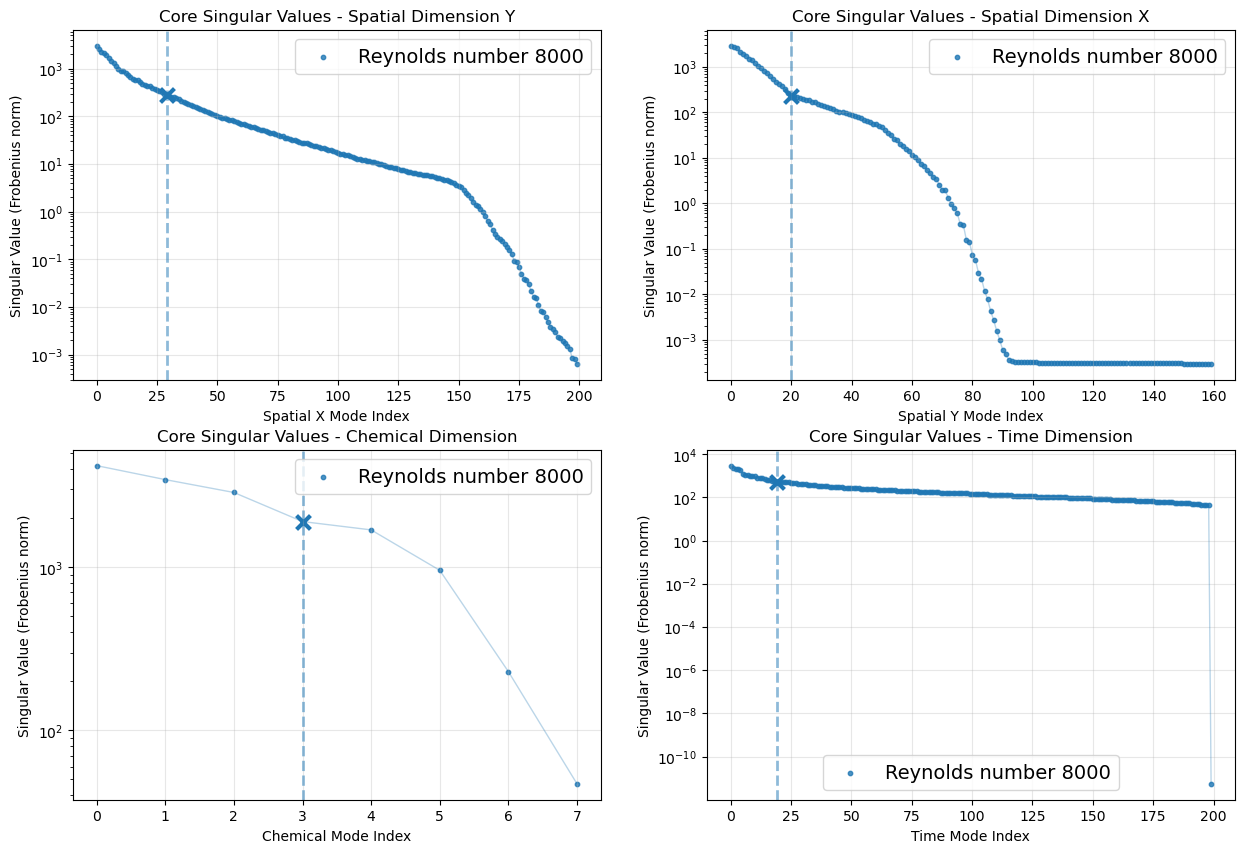

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(decomposition_results)))

for idx, (key, f) in enumerate(decomposition_results.items()):
    core = f['core']
    dataset_name = f"Reynolds number {key.split('-')[-1][:4]}"
    color = colors[idx]
    
    # Mode 0 - Spatial X
    sv_0 = np.array([np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])])
    # Find elbow: maximum perpendicular distance from line connecting first and last point
    n_points = len(sv_0)
    # Normalize coordinates
    x_norm = np.arange(n_points) / (n_points - 1)
    y_norm = (sv_0 - sv_0.min()) / (sv_0.max() - sv_0.min())
    # Calculate perpendicular distances
    distances = np.abs((y_norm[-1] - y_norm[0]) * x_norm - (x_norm[-1] - x_norm[0]) * y_norm + x_norm[-1] * y_norm[0] - y_norm[-1] * x_norm[0])
    distances /= np.sqrt((y_norm[-1] - y_norm[0])**2 + (x_norm[-1] - x_norm[0])**2)
    elbow_0 = np.argmax(distances)
    
    ax = axes[0, 0]
    ax.scatter(range(len(sv_0)), sv_0, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_0)), sv_0, color=color, alpha=0.3, linewidth=1)
    ax.axvline(elbow_0, color=color, linestyle='--', alpha=0.5, linewidth=2)
    ax.scatter([elbow_0], [sv_0[elbow_0]], color=color, s=100, marker='x', linewidths=3)
    
    # Mode 1 - Spatial Y
    sv_1 = np.array([np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])])
    n_points = len(sv_1)
    x_norm = np.arange(n_points) / (n_points - 1)
    y_norm = (sv_1 - sv_1.min()) / (sv_1.max() - sv_1.min())
    distances = np.abs((y_norm[-1] - y_norm[0]) * x_norm - (x_norm[-1] - x_norm[0]) * y_norm + x_norm[-1] * y_norm[0] - y_norm[-1] * x_norm[0])
    distances /= np.sqrt((y_norm[-1] - y_norm[0])**2 + (x_norm[-1] - x_norm[0])**2)
    elbow_1 = np.argmax(distances)
    
    ax = axes[0, 1]
    ax.scatter(range(len(sv_1)), sv_1, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_1)), sv_1, color=color, alpha=0.3, linewidth=1)
    ax.axvline(elbow_1, color=color, linestyle='--', alpha=0.5, linewidth=2)
    ax.scatter([elbow_1], [sv_1[elbow_1]], color=color, s=100, marker='x', linewidths=3)
    
    # Chemical mode
    sv_chem = np.array([np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])])
    n_points = len(sv_chem)
    x_norm = np.arange(n_points) / (n_points - 1)
    y_norm = (sv_chem - sv_chem.min()) / (sv_chem.max() - sv_chem.min())
    distances = np.abs((y_norm[-1] - y_norm[0]) * x_norm - (x_norm[-1] - x_norm[0]) * y_norm + x_norm[-1] * y_norm[0] - y_norm[-1] * x_norm[0])
    distances /= np.sqrt((y_norm[-1] - y_norm[0])**2 + (x_norm[-1] - x_norm[0])**2)
    elbow_chem = np.argmax(distances)
    
    ax = axes[1, 0]
    ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=0.3, linewidth=1)
    ax.axvline(elbow_chem, color=color, linestyle='--', alpha=0.5, linewidth=2)
    ax.scatter([elbow_chem], [sv_chem[elbow_chem]], color=color, s=100, marker='x', linewidths=3)
    
    # Time mode
    sv_time = np.array([np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])])
    n_points = len(sv_time)
    x_norm = np.arange(n_points) / (n_points - 1)
    y_norm = (sv_time - sv_time.min()) / (sv_time.max() - sv_time.min())
    distances = np.abs((y_norm[-1] - y_norm[0]) * x_norm - (x_norm[-1] - x_norm[0]) * y_norm + x_norm[-1] * y_norm[0] - y_norm[-1] * x_norm[0])
    distances /= np.sqrt((y_norm[-1] - y_norm[0])**2 + (x_norm[-1] - x_norm[0])**2)
    elbow_time = np.argmax(distances)
    
    ax = axes[1, 1]
    ax.scatter(range(len(sv_time)), sv_time, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_time)), sv_time, color=color, alpha=0.3, linewidth=1)
    ax.axvline(elbow_time, color=color, linestyle='--', alpha=0.5, linewidth=2)
    ax.scatter([elbow_time], [sv_time[elbow_time]], color=color, s=100, marker='x', linewidths=3)
    
    print(f"{dataset_name} - Elbows: X={elbow_0}, Y={elbow_1}, Chem={elbow_chem}, Time={elbow_time}")
ax = axes[0, 0]
ax.set_xlabel('Spatial X Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension Y') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[0, 1]
ax.set_xlabel('Spatial Y Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension X') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 0]
ax.set_xlabel('Chemical Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Chemical Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 1]
ax.set_xlabel('Time Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Time Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')
